In [1]:
import os, shutil
import keras
import numpy as np
import tensorflow as tf
from keras import layers
from keras.utils import image_dataset_from_directory

In [2]:
!unzip train_val_test.zip

Archive:  train_val_test.zip
 extracting: test.zip                
 extracting: train.zip               
 extracting: val.zip                 


In [3]:
!unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/happy/PublicTest_11555220.jpg  
  inflating: train/happy/Training_42525079.jpg  
  inflating: train/happy/PrivateTest_45765115.jpg  
  inflating: train/happy/Training_29662843.jpg  
  inflating: train/happy/Training_27995804.jpg  
  inflating: train/happy/Training_74960993.jpg  
  inflating: train/happy/Training_9062090.jpg  
  inflating: train/happy/Training_75614920.jpg  
  inflating: train/happy/Training_28013108.jpg  
  inflating: train/happy/PrivateTest_41085315.jpg  
  inflating: train/happy/Training_74794895.jpg  
  inflating: train/happy/Training_69994910.jpg  
  inflating: train/happy/Training_97247380.jpg  
  inflating: train/happy/Training_99666856.jpg  
  inflating: train/happy/Training_26564705.jpg  
  inflating: train/happy/Training_79130557.jpg  
  inflating: train/happy/Training_76469395.jpg  
  inflating: train/happy/PrivateTest_69814564.jpg  
  inflating: train/happy/Training_22839654.jpg  
  inflat

In [4]:
!unzip val.zip

Streaming output truncated to the last 5000 lines.
  inflating: val/angry/angry3798.jpg  
  inflating: val/angry/Training_3601553.jpg  
  inflating: val/angry/PrivateTest_70837533.jpg  
  inflating: val/angry/angry1272.jpg  
  inflating: val/angry/angry1325.jpg  
  inflating: val/angry/angry2553.jpg  
  inflating: val/angry/Training_39805082.jpg  
  inflating: val/angry/angry2334.jpg  
  inflating: val/angry/Training_36395815.jpg  
  inflating: val/angry/Training_97311919.jpg  
  inflating: val/angry/Training_37846297.jpg  
  inflating: val/angry/angry702.jpg  
  inflating: val/angry/Training_90271872.jpg  
  inflating: val/angry/Training_79301469.jpg  
  inflating: val/angry/Training_83671130.jpg  
  inflating: val/angry/angry248.jpg  
  inflating: val/angry/Training_82314175.jpg  
  inflating: val/angry/Training_8917656.jpg  
  inflating: val/angry/angry1943.jpg  
  inflating: val/angry/PublicTest_42826491.jpg  
  inflating: val/angry/angry2195.jpg  
  inflating: val/angry/Training_2

In [5]:
!unzip test.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/sad/Training_67094111.jpg  
  inflating: test/sad/sad1051.jpg    
  inflating: test/sad/sad1900.jpg    
  inflating: test/sad/Training_97360221.jpg  
  inflating: test/sad/Training_26809713.jpg  
  inflating: test/sad/sad864.jpg     
  inflating: test/sad/Training_22358838.jpg  
  inflating: test/sad/sad2769.jpg    
  inflating: test/sad/sad2779.jpg    
  inflating: test/sad/Training_60572916.jpg  
  inflating: test/sad/Training_12396877.jpg  
  inflating: test/sad/Training_43234355.jpg  
  inflating: test/sad/sad2650.jpg    
  inflating: test/sad/Training_54757164.jpg  
  inflating: test/sad/Training_33455689.jpg  
  inflating: test/sad/Training_19952390.jpg  
  inflating: test/sad/sad1841.jpg    
  inflating: test/sad/Training_70091553.jpg  
  inflating: test/sad/sad64.jpg      
  inflating: test/sad/PublicTest_30717850.jpg  
  inflating: test/sad/Training_65586139.jpg  
  inflating: test/sad/Training_27359156.jpg  

# Verify Balanced Data

In [ ]:
d = {}
types = ["test", "train", "val"]
for dir_type in types:
    for folder in os.listdir(dir_type):
        files = os.listdir(os.path.join(dir_type, folder))
        if(folder not in d):
            d[folder] = len(files)
        else:
            d[folder] += len(files)
for class_type in d:
    assert(d[class_type] == 8989)

# Obtain the Data Generators

In [15]:
train_dir = os.path.join("train")
val_dir = os.path.join("val")
test_dir = os.path.join("test")

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(48, 48),
    label_mode="categorical",
    color_mode='grayscale',
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    val_dir,
    image_size=(48, 48),
    label_mode="categorical",
    color_mode='grayscale',
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(48, 48),
    label_mode="categorical",
    color_mode='grayscale',
    batch_size=32
)

Found 44044 files belonging to 7 classes.
Found 12586 files belonging to 7 classes.
Found 6293 files belonging to 7 classes.


# Example of data

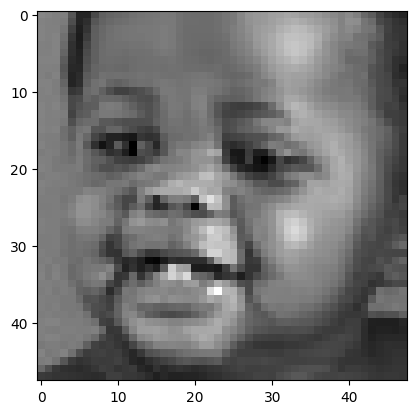

In [49]:
for images, labels in validation_dataset.take(1):
    plt.imshow(images[0].numpy().astype('uint8'), cmap='gray')
    plt.show()
    break

# Build and Fit the Model

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [ ]:
inputs = keras.Input(shape=(48, 48, 1))
x = data_augmentation(inputs) # apply data augmentation
x = layers.Rescaling(1./255)(x) # apply input scaling
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)
for size in [32, 64, 128, 256, 512]: # increasing feature depth
    residual = x # obtain residual
    x = layers.BatchNormalization()(x) # batch normalization
    x = layers.Activation("relu")(x) # ReLU activation
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x) # sepearable instead of regular convolutional layer
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x) # max pooling
    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual) # size down residual
    x = layers.add([x, residual]) # combine residual with output
x = layers.GlobalAveragePooling2D()(x) # we do gloal average pooling instead of flatten
x = layers.Dropout(0.5)(x) # for regularization
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam", # adam optimization algorithm
              metrics=["accuracy"]
              )

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 48, 48, 1)            0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 48, 48, 1)            0         ['sequential[0][0]']          
                                                                                                  
 conv2d (Conv2D)             (None, 44, 44, 32)           800       ['rescaling[0][0]']           
                                                                                              

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="best_loss_model.h5",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.ModelCheckpoint(
        filepath="best_acc_model.h5",
        save_best_only=True,
        monitor="val_accuracy")
]

history = model.fit(
    train_dataset,
    epochs=150,
    validation_data=validation_dataset,
    callbacks=callbacks
)
model.save("end_model.h5")

Epoch 1/150
1377/1377 [==============================] - ETA: 0s - loss: 1.7846 - accuracy: 0.2883

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1377/1377 [==============================] - 56s 25ms/step - loss: 1.7846 - accuracy: 0.2883 - val_loss: 2.4629 - val_accuracy: 0.2267
Epoch 2/150
1377/1377 [==============================] - 32s 23ms/step - loss: 1.5541 - accuracy: 0.4031 - val_loss: 1.5423 - val_accuracy: 0.4103
Epoch 3/150
1377/1377 [==============================] - 32s 23ms/step - loss: 1.4327 - accuracy: 0.4511 - val_loss: 1.3205 - val_accuracy: 0.4936
Epoch 4/150
1377/1377 [==============================] - 30s 22ms/step - loss: 1.3757 - accuracy: 0.4756 - val_loss: 1.3642 - val_accuracy: 0.4801
Epoch 5/150
1377/1377 [==============================] - 30s 22ms/step - loss: 1.3356 - accuracy: 0.4912 - val_loss: 1.3155 - val_accuracy: 0.4975
Epoch 6/150
1377/1377 [==============================] - 29s 21ms/step - loss: 1.3005 - accuracy: 0.5040 - val_loss: 1.2514 - val_accuracy: 0.5295
Epoch 7/150
1377/1377 [==============================] - 28s 21ms/step - loss: 1.2714 - accuracy: 0.5138 - val_loss: 1.2672 - val_

# Training and Validation Training and Loss Graphs

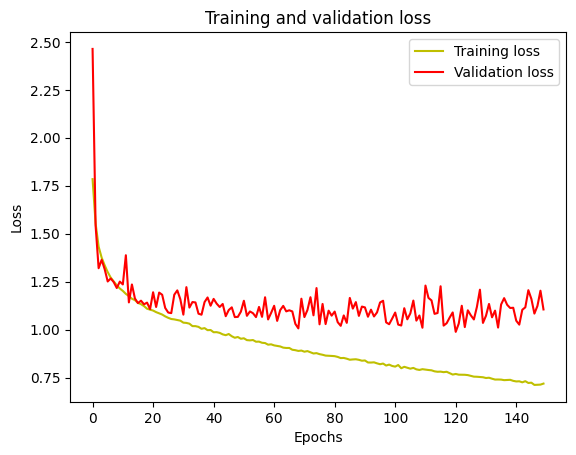

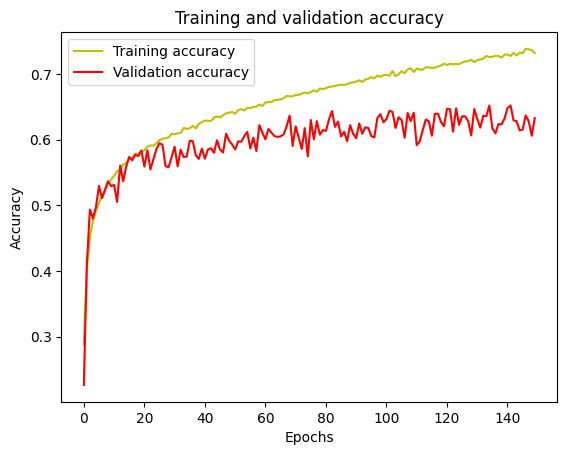

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.plot(history.history["loss"], "y", label="Training loss")
plt.plot(history.history["val_loss"], "r", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.plot(history.history["accuracy"], "y", label="Training accuracy")
plt.plot(history.history["val_accuracy"], "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# Test the obtained models on the test data

In [ ]:
model = keras.models.load_model("end_model.h5")
test_loss, test_acc = model.evaluate(test_dataset, steps=50)
print('test acc:', test_acc)

50/50 [==============================] - 0s 6ms/step - loss: 1.0831 - accuracy: 0.6363
test acc: 0.6362500190734863


In [ ]:
model = keras.models.load_model("best_acc_model.h5")
test_loss, test_acc = model.evaluate(test_dataset, steps=50)
print('test acc:', test_acc)

50/50 [==============================] - 1s 7ms/step - loss: 1.0072 - accuracy: 0.6469
test acc: 0.6468750238418579


In [ ]:
model = keras.models.load_model("best_loss_model.h5") # this is the best model
test_loss, test_acc = model.evaluate(test_dataset, steps=50)
print('test acc:', test_acc)

50/50 [==============================] - 1s 6ms/step - loss: 0.9623 - accuracy: 0.6650
test acc: 0.6650000214576721


# We have obtained a classifier with 66.5% accuracy

In [7]:
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

# Create the Confusion Matrix

In [10]:
import cv2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model = keras.models.load_model("best_loss_model_64.h5")
y_pred = []
y_label = []
images = []
for i in range(len(classes)):
    class_name = classes[i]
    dir = os.path.join("test", class_name)
    files = os.listdir(dir)
    for file_name in files:
        y_label.append(i)
        image = cv2.imread(os.path.join(dir, file_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.reshape(image, (1, 48, 48, 1))
        images.append(image)
images = np.vstack(images)
y_label = np.vstack(y_label)

predictions = model.predict(images)
y_pred = predictions.argmax(axis=1)

197/197 [==============================] - 17s 84ms/step


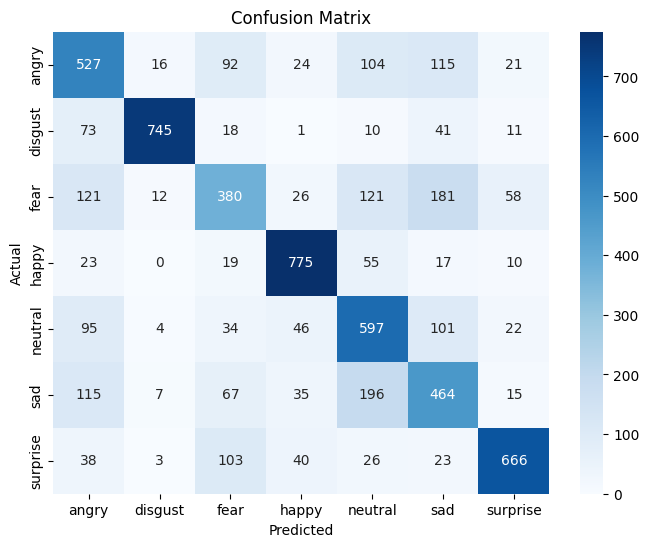

In [24]:
cm = confusion_matrix(y_label, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
def get_predictions(model, dataset):
    all_predictions = []
    all_labels = []
    for images, labels in dataset:
        predictions = model.predict(images)
        all_predictions.append(predictions)
        all_labels.append(labels)
    return np.concatenate(all_predictions), np.concatenate(all_labels)

fine_tuned_predictions, fine_tuned_labels = get_predictions(model, test_dataset)

1/1 [==============================] - 1s 522ms/step


In [17]:
predicted_classes_ft = np.argmax(fine_tuned_predictions, axis=1)
true_classes_ft = np.argmax(fine_tuned_labels, axis=1)

# Graph the ROC Curves

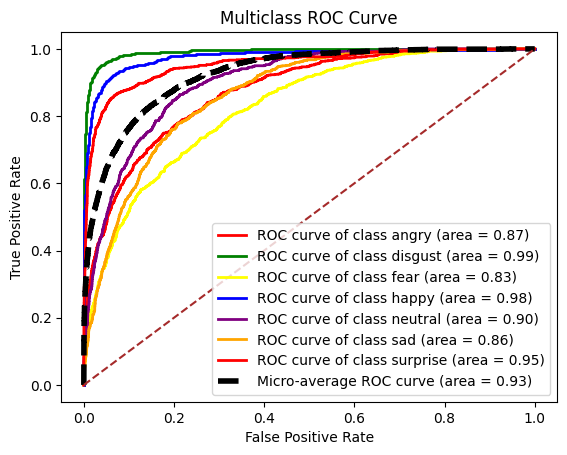

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(classes)

test_labels_bin_ft = label_binarize(true_classes_ft, classes=range(n_classes))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin_ft[:, i], fine_tuned_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_bin_ft.ravel(), fine_tuned_predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()

colors = cycle(['red', 'green', 'yellow', 'blue', 'purple', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='black', linestyle='--', linewidth=4)

plt.plot([0, 1], [0, 1], color='brown', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Generate Precision and Recall Metrics

In [19]:
from sklearn.metrics import classification_report

report = classification_report(true_classes_ft, predicted_classes_ft, target_names=classes)
print(report)

              precision    recall  f1-score   support

       angry       0.54      0.60      0.57       899
     disgust       0.95      0.83      0.89       899
        fear       0.52      0.41      0.46       899
       happy       0.82      0.86      0.84       899
     neutral       0.54      0.66      0.59       899
         sad       0.50      0.54      0.52       899
    surprise       0.83      0.73      0.78       899

    accuracy                           0.66      6293
   macro avg       0.67      0.66      0.66      6293
weighted avg       0.67      0.66      0.66      6293

